# Edited: Sama
# Spleen 3D CT Regression with MONAI



## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib


from monai.utils import first, set_determinism
from monai.transforms import (EnsureChannelFirstd, Compose, CropForegroundd, LoadImaged, Orientationd, RandCropByPosNegLabeld, ScaleIntensityRanged, Spacingd)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn

2023-12-18 17:18:40.056727: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 17:18:40.056839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 17:18:40.163027: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 17:18:42.322052: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Set MSD Spleen dataset path

In [2]:
from google.colab import drive
drive.mount('/content/drive')
root_dir = '/content/drive/My Drive/MONAI_data'
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"
os.makedirs(root_dir, exist_ok=True)
compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
# Create data dictionaries
data_dicts = [{"image": img, "target": img} for img in train_images]
# making  smaller input to save time for practing stage:
train_files, val_files = data_dicts[-9:], data_dicts[-9:]

set_determinism(seed=0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Define CacheDataset and DataLoader

In [13]:

train_transforms = Compose(
    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        ScaleIntensityRanged(keys=["image", "target"], a_min=-1024, a_max=2048, b_min=0.0, b_max=1.0, clip=True),
        # CropForegroundd(keys=["image", "target"], source_key="image"),
        Orientationd(keys=["image", "target"], axcodes="RAS"),
        Spacingd(keys=["image", "target"], pixdim=(1.5, 1.5, 2.0), mode=("trilinear", "trilinear")),
        RandCropByPosNegLabeld(keys=["image", "target"],label_key="target", spatial_size=(96, 96, 96), pos=1, neg=1, num_samples=4,image_key="image",image_threshold=0),
        ])

val_transforms = Compose(
    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        ScaleIntensityRanged(keys=["image", "target"], a_min=-1024, a_max=2048, b_min=0.0, b_max=1.0, clip=True),
        # CropForegroundd(keys=["image", "target"], source_key="image"),
        Orientationd(keys=["image", "target"], axcodes="RAS"),
        Spacingd(keys=["image", "target"], pixdim=(1.5, 1.5, 2.0), mode=("trilinear", "trilinear")),
        # RandCropByPosNegLabeld(keys=["image", "target"],label_key="target", spatial_size=(96, 96, 96), pos=1, neg=1, num_samples=4,image_key="image",image_threshold=0),
        ])

train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=2)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)


Loading dataset: 100%|██████████| 9/9 [00:35<00:00,  3.91s/it]


image shape: torch.Size([239, 239, 113]), target shape: torch.Size([239, 239, 113])


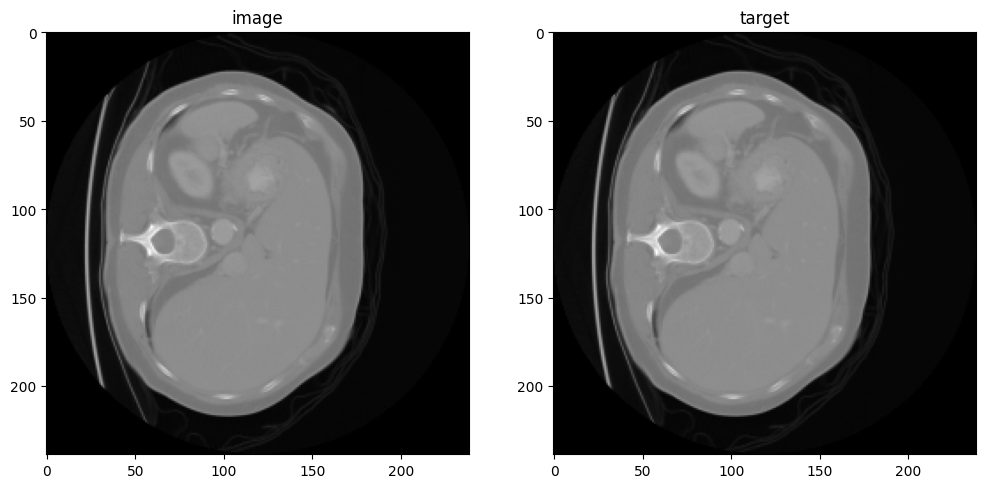

In [14]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, target = (check_data["image"][0][0], check_data["target"][0][0])
print(f"image shape: {image.shape}, target shape: {target.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("target")
plt.imshow(target[:, :, 80], cmap= "gray")
plt.show()

## Create Model, Loss, Optimizer

In [15]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64), # reducing the depth of the network and the number of channels in each convolutional layer
    act=(nn.ReLU, {"inplace": True}),
    strides=(2, 2), #  fewer downsampling and upsampling operations
    num_res_units=2, # is reduced to 1, reducing the complexity within each block of the network.
    norm=Norm.BATCH,
).to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

## Execute a typical PyTorch training process

In [16]:

max_epochs = 4
val_interval = 2
best_metric = float('inf')
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["target"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["target"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_loss += loss_function(val_outputs, val_labels).item()

            val_loss /= len(val_loader)
            metric_values.append(val_loss)
            if val_loss < best_metric:
                best_metric = val_loss
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current val loss: {val_loss:.4f}"
                f"\nbest val loss: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )


----------
epoch 1/4


/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 7711017, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 8330572, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 5164029, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 13824826, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 8419958, Num backgrounds 0, unable to gener

1/2, train_loss: 0.5131
2/2, train_loss: 0.4380
3/2, train_loss: 0.3795
epoch 1 average loss: 0.4435
----------
epoch 2/4


/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 5093927, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 7711017, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 13824826, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 5164029, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 8330572, Num backgrounds 0, unable to gener

1/2, train_loss: 0.3512
2/2, train_loss: 0.3342
3/2, train_loss: 0.3395
epoch 2 average loss: 0.3416
saved new best metric model
current epoch: 2 current val loss: 0.0219
best val loss: 0.0219 at epoch: 2
----------
epoch 3/4


/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 5164029, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 5093927, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 17029498, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 8419958, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 6471935, Num backgrounds 0, unable to gener

1/2, train_loss: 0.2819
2/2, train_loss: 0.2750
3/2, train_loss: 0.3004
epoch 3 average loss: 0.2858
----------
epoch 4/4


/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 9849595, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 13824826, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 5164029, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 5093927, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 7711017, Num backgrounds 0, unable to gener

1/2, train_loss: 0.2347
2/2, train_loss: 0.1876
3/2, train_loss: 0.1722
epoch 4 average loss: 0.1982
current epoch: 4 current val loss: 0.0288
best val loss: 0.0219 at epoch: 2


## Plot the loss and metric

train completed, best_metric: 0.0219 at epoch: 2


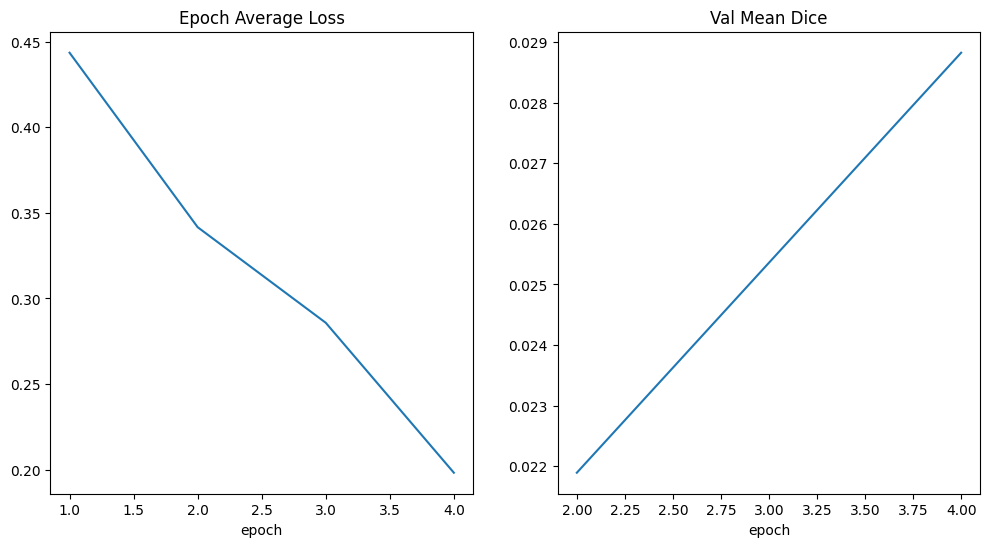

In [17]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

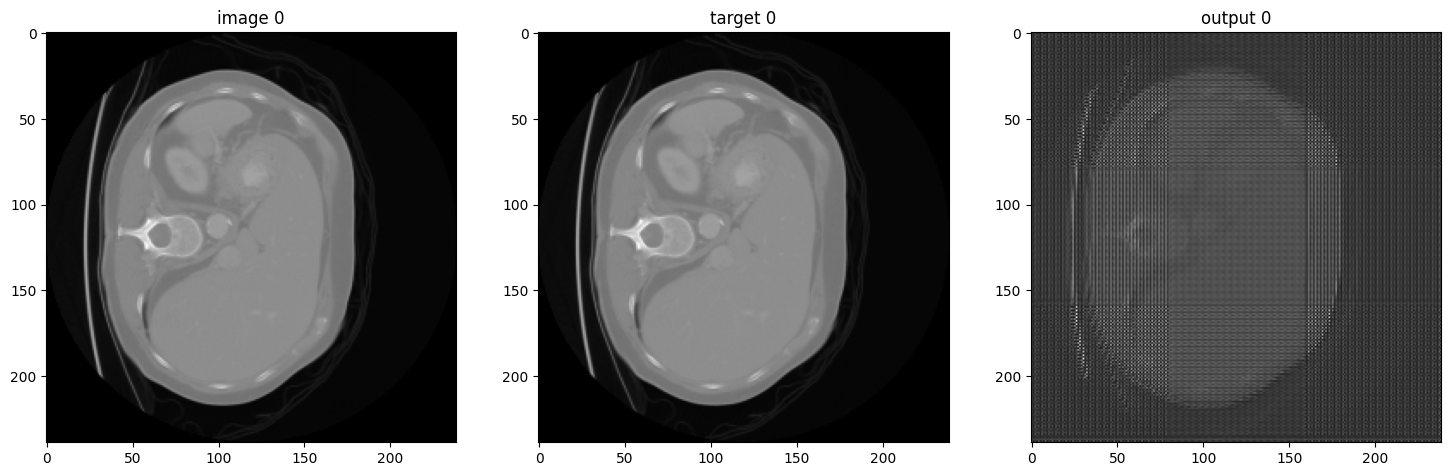

In [18]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)

        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")

        plt.subplot(1, 3, 2)
        plt.title(f"target {i}")
        plt.imshow(val_data["target"][0, 0, :, :, 80], cmap="gray")

        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        output_slice = val_outputs.detach().cpu()[0, 0, :, :, 80]
        # Assuming the output values are normalized, adjust if not
        plt.imshow(output_slice, cmap="gray")
        plt.show()
        if i == 0:
            break


---------------------

In [9]:
# val_org_transforms = Compose(
#     [
#         LoadImaged(keys=["image", "target"]),
#         EnsureChannelFirstd(keys=["image", "target"]),
#         Orientationd(keys=["image"], axcodes="RAS"),
#         Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
#         ScaleIntensityRanged(
#             keys=["image"],
#             a_min=-57,
#             a_max=164,
#             b_min=0.0,
#             b_max=1.0,
#             clip=True,
#         ),
#         CropForegroundd(keys=["image"], source_key="image"),
#     ]
# )

# val_org_ds = Dataset(data=val_files, transform=val_org_transforms)
# val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

# post_transforms = Compose(
#     [
#         Invertd(
#             keys="pred",
#             transform=val_org_transforms,
#             orig_keys="image",
#             meta_keys="pred_meta_dict",
#             orig_meta_keys="image_meta_dict",
#             meta_key_postfix="meta_dict",
#             nearest_interp=False,
#             to_tensor=True,
#             device="cpu",
#         ),
#         AsDiscreted(keys="pred", argmax=True, to_onehot=2),
#         AsDiscreted(keys="target", to_onehot=2),
#     ]
# )

In [10]:
# model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
# model.eval()

# with torch.no_grad():
#     for val_data in val_org_loader:
#         val_inputs = val_data["image"].to(device)
#         roi_size = (160, 160, 160)
#         sw_batch_size = 4
#         val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
#         val_data = [post_transforms(i) for i in decollate_batch(val_data)]
#         val_outputs, val_labels = from_engine(["pred", "target"])(val_data)
#         # compute metric for current iteration
#         dice_metric(y_pred=val_outputs, y=val_labels)

#     # aggregate the final mean dice result
#     metric_org = dice_metric.aggregate().item()
#     # reset the status for next validation round
#     dice_metric.reset()

# print("Metric on original image spacing: ", metric_org)

In [11]:
# test_images = sorted(glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

# test_data = [{"image": image} for image in test_images]


# test_org_transforms = Compose(
#     [
#         LoadImaged(keys="image"),
#         EnsureChannelFirstd(keys="image"),
#         Orientationd(keys=["image"], axcodes="RAS"),
#         Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
#         ScaleIntensityRanged(
#             keys=["image"],
#             a_min=-57,
#             a_max=164,
#             b_min=0.0,
#             b_max=1.0,
#             clip=True,
#         ),
#         CropForegroundd(keys=["image"], source_key="image"),
#     ]
# )

# test_org_ds = Dataset(data=test_data, transform=test_org_transforms)

# test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

# post_transforms = Compose(
#     [
#         Invertd(
#             keys="pred",
#             transform=test_org_transforms,
#             orig_keys="image",
#             meta_keys="pred_meta_dict",
#             orig_meta_keys="image_meta_dict",
#             meta_key_postfix="meta_dict",
#             nearest_interp=False,
#             to_tensor=True,
#         ),
#         AsDiscreted(keys="pred", argmax=True, to_onehot=2),
#         SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
#     ]
# )

In [12]:
# model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
# model.eval()

# with torch.no_grad():
#     for test_data in test_org_loader:
#         test_inputs = test_data["image"].to(device)
#         roi_size = (160, 160, 160)
#         sw_batch_size = 4
#         test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)

#         test_data = [post_transforms(i) for i in decollate_batch(test_data)]

# #         # uncomment the following lines to visualize the predicted results
# #         test_output = from_engine(["pred"])(test_data)

# #         original_image = loader(test_output[0].meta["filename_or_obj"])

# #         plt.figure("check", (18, 6))
# #         plt.subplot(1, 2, 1)
# #         plt.imshow(original_image[:, :, 20], cmap="gray")
# #         plt.subplot(1, 2, 2)
# #         plt.imshow(test_output[0].detach().cpu()[1, :, :, 20])
# #         plt.show()